<AxesSubplot: >

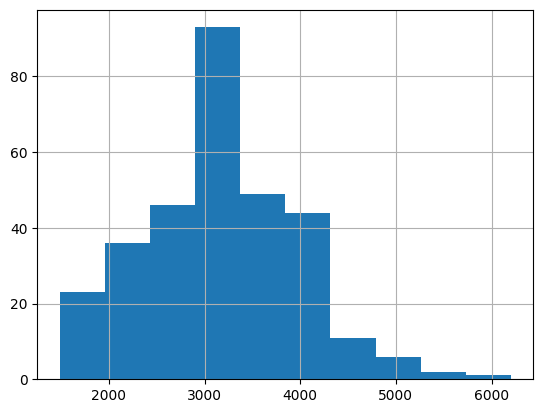

In [183]:
import pandas as pd

data_terminated = pd.read_csv("terminated_data.csv", index_col=["Unnamed: 0"])
data_employed = pd.read_csv("employed_data.csv", index_col=["Unnamed: 0"])
data_terminated["DateofTermination"] = pd.to_datetime(
    data_terminated["DateofTermination"]
)
data_terminated["DateofHire"] = pd.to_datetime(data_terminated["DateofHire"])
data_terminated["EmploymentTime"] = (data_terminated["DateofTermination"] - data_terminated["DateofHire"]).dt.days

data_employed
data_employed["DateofHire"] = pd.to_datetime(data_employed["DateofHire"])
data_employed["EmploymentTime"] = (pd.to_datetime("2023/01/01") - data_employed["DateofHire"]).dt.days

pd.concat([data_terminated["EmploymentTime"], data_employed["EmploymentTime"]]).hist()

In [184]:
print(data_terminated[["PerfScore", "AssColl", "AssSelf", "AssLead"]].mean())
print(data_employed[["PerfScore", "AssColl", "AssSelf", "AssLead"]].mean())
print(data_terminated[["PerfScore", "AssColl", "AssSelf", "AssLead"]].std())
print(data_employed[["PerfScore", "AssColl", "AssSelf", "AssLead"]].std())
print(len(data_terminated), len(data_employed))


PerfScore    2.653846
AssColl      2.461538
AssSelf      2.500000
AssLead      2.490385
dtype: float64
PerfScore    3.135266
AssColl      3.135266
AssSelf      3.338164
AssLead      3.304348
dtype: float64
PerfScore    0.772956
AssColl      0.902242
AssSelf      0.995134
AssLead      0.995087
dtype: float64
PerfScore    0.830874
AssColl      0.898252
AssSelf      0.903952
AssLead      1.014042
dtype: float64
104 207


In [185]:
import scipy
import numpy as np


def test_difference(left, right, alpha):
    diff = left.mean() - right.mean()
    sd_l = left.std()
    sd_r = right.std()
    n_l = len(left)
    n_r = len(right)
    dof = n_l + n_r - 2
    if n_l == 0 or n_r == 0:
        return

    t_stat = diff / np.sqrt(sd_l**2 / n_l + sd_r**2 / n_r)

    t_critical = scipy.stats.t.ppf(alpha, dof)
    print(
        f"H0: mean(x_l) [{left.mean():.1f}] - mean(x_r) [{right.mean():.1f}] < 0 [{diff:.1f}]:",
        t_stat < abs(t_critical),
        "\np-value:",
        round(1 - scipy.stats.t.cdf(t_stat, dof), 4),
    )


test_difference(data_terminated["PerfScore"], data_employed["PerfScore"], 0.05)
test_difference(data_terminated["AssColl"], data_employed["AssColl"], 0.05)
test_difference(data_terminated["AssSelf"], data_employed["AssSelf"], 0.05)
test_difference(data_terminated["AssLead"], data_employed["AssLead"], 0.05)
test_difference(
    data_terminated[data_terminated["Department"] == "Software Engineering"]["TechLev"],
    data_employed[data_employed["Department"] == "Software Engineering"]["TechLev"],
    0.05,
)


H0: mean(x_l) [2.7] - mean(x_r) [3.1] < 0 [-0.5]: True 
p-value: 1.0
H0: mean(x_l) [2.5] - mean(x_r) [3.1] < 0 [-0.7]: True 
p-value: 1.0
H0: mean(x_l) [2.5] - mean(x_r) [3.3] < 0 [-0.8]: True 
p-value: 1.0
H0: mean(x_l) [2.5] - mean(x_r) [3.3] < 0 [-0.8]: True 
p-value: 1.0
H0: mean(x_l) [3.5] - mean(x_r) [5.1] < 0 [-1.6]: True 
p-value: 0.8701


In [207]:
def test_difference_per_department(term, emp):
    for dep in term.Department.unique():
        print(f"--- Department : {dep} ---")
        for score in ["PerfScore", "AssColl", "AssSelf", "AssLead", "TechLev", "EmploymentTime"]:
            print(f"score: {score}")
            test_difference(
                data_terminated[data_terminated["EmploymentStatus"] == "Voluntarily Terminated"][data_terminated["Department"] == dep][score],
                data_employed[data_employed["Department"] == dep][score],
                0.05,
            )

def test_difference_per_departure_time(term, emp):
    for dep in [("2000/1/1", "2016/12/31"), ("2017/1/1", "2019/12/31"), ("2020/1/1", "2023/12/31")]:
        print(f"--- Departure Time : {dep} ---")
        for score in ["PerfScore", "AssColl", "AssSelf", "AssLead", "TechLev", "EmploymentTime"]:
            print(f"score: {score}")
            test_difference(
                data_terminated[data_terminated["EmploymentStatus"] == "Voluntarily Terminated"][data_terminated["DateofTermination"] >= dep[0]][data_terminated["DateofTermination"] <= dep[1]][score],
                data_employed[data_employed["DateofHire"] <= dep[1]][score],
                0.05,
            )


In [208]:
# test_difference_per_department(data_terminated, data_employed)
test_difference_per_departure_time(data_terminated, data_employed)


--- Departure Time : ('2000/1/1', '2016/12/31') ---
score: PerfScore
H0: mean(x_l) [2.7] - mean(x_r) [3.1] < 0 [-0.4]: True 
p-value: 0.938
score: AssColl
H0: mean(x_l) [2.2] - mean(x_r) [3.1] < 0 [-0.9]: True 
p-value: 0.9978
score: AssSelf
H0: mean(x_l) [2.4] - mean(x_r) [3.3] < 0 [-0.9]: True 
p-value: 0.9988
score: AssLead
H0: mean(x_l) [2.5] - mean(x_r) [3.3] < 0 [-0.8]: True 
p-value: 0.9922
score: TechLev
H0: mean(x_l) [4.4] - mean(x_r) [5.2] < 0 [-0.8]: True 
p-value: 0.9083
score: EmploymentTime
H0: mean(x_l) [1875.5] - mean(x_r) [3462.6] < 0 [-1587.1]: True 
p-value: 1.0
--- Departure Time : ('2017/1/1', '2019/12/31') ---
score: PerfScore
H0: mean(x_l) [2.6] - mean(x_r) [3.1] < 0 [-0.5]: True 
p-value: 1.0
score: AssColl
H0: mean(x_l) [2.5] - mean(x_r) [3.1] < 0 [-0.6]: True 
p-value: 0.9999
score: AssSelf
H0: mean(x_l) [2.5] - mean(x_r) [3.3] < 0 [-0.8]: True 
p-value: 1.0
score: AssLead
H0: mean(x_l) [2.2] - mean(x_r) [3.3] < 0 [-1.1]: True 
p-value: 1.0
score: TechLev
H0: 

C:\Users\Albin\AppData\Local\Temp\ipykernel_8248\289581980.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_terminated[data_terminated["EmploymentStatus"] == "Voluntarily Terminated"][data_terminated["DateofTermination"] >= dep[0]][data_terminated["DateofTermination"] <= dep[1]][score],


In [189]:
data_terminated["MeanPerScore"] = (
    data_terminated["PerfScore"]
    + data_terminated["AssColl"]
    + data_terminated["AssSelf"]
    + data_terminated["AssLead"]
    + data_terminated["TechLev"]
) / 5
data_employed["MeanPerScore"] = (
    data_employed["PerfScore"]
    + data_employed["AssColl"]
    + data_employed["AssSelf"]
    + data_employed["AssLead"]
    + data_employed["TechLev"]
) / 5

test_difference(
    data_terminated[
        data_terminated["TermReason"].isin(["career change", "Another position"])
    ]["MeanPerScore"],
    data_employed["MeanPerScore"],
    0.01,
)


H0: mean(x_l) [2.8] - mean(x_r) [3.6] < 0 [-0.8]: True 
p-value: 1.0


In [190]:
data_employed.groupby("Department")[
    ["PerfScore", "AssColl", "AssSelf", "AssLead", "TechLev"]
].corr()


PerfScore   AssColl   AssSelf   AssLead  \
Department                                                                
Admin Offices        PerfScore   1.000000  0.271163 -0.198030  0.498527   
                     AssColl     0.271163  1.000000 -0.730297  0.353553   
                     AssSelf    -0.198030 -0.730297  1.000000 -0.258199   
                     AssLead     0.498527  0.353553 -0.258199  1.000000   
                     TechLev     0.336336  0.444458 -0.113228  0.233882   
Executive Office     PerfScore        NaN       NaN       NaN       NaN   
                     AssColl          NaN       NaN       NaN       NaN   
                     AssSelf          NaN       NaN       NaN       NaN   
                     AssLead          NaN       NaN       NaN       NaN   
                     TechLev          NaN       NaN       NaN       NaN   
IT/IS                PerfScore   1.000000  0.107774  0.259974  0.305471   
                     AssColl     0.107774  1.000000 -0.234764  0.435898   
                     AssSelf     0.259974 -0.234764  1.000000  0.285273   
                     AssLead     0.305471  0.435898  0.285273  1.000000   
                     TechLev     0.042063 -0.299216 -0.067843 -0.192366   
Production           PerfScore   1.000000  0.203611 -0.062828  0.363210   
                     AssColl     0.203611  1.000000 -0.048708  0.340483   
                     AssSelf    -0.062828 -0.048708  1.000000  0.110177   
                     AssLead     0.363210  0.340483  0.110177  1.000000   
                     TechLev     0.015955 -0.122896 -0.080261 -0.085389   
Sales                PerfScore   1.000000  0.572572  0.492951  0.485046   
                     AssColl     0.572572  1.000000  0.578120  0.561287   
                     AssSelf     0.492951  0.578120  1.000000  0.580613   
                     AssLead     0.485046  0.561287  0.580613  1.000000   
                     TechLev     0.066807 -0.125921 -0.087294  0.022450   
Software Engineering PerfScore   1.000000 -0.193122  0.131559  0.372104   
                     AssColl    -0.193122  1.000000 -0.825723  0.253012   
                     AssSelf     0.131559 -0.825723  1.000000 -0.388909   
                     AssLead     0.372104  0.253012 -0.388909  1.000000   
                     TechLev    -0.672439  0.129863  0.117954 -0.177237   

                                 TechLev  
Department                                
Admin Offices        PerfScore  0.336336  
                     AssColl    0.444458  
                     AssSelf   -0.113228  
                     AssLead    0.233882  
                     TechLev    1.000000  
Executive Office     PerfScore       NaN  
                     AssColl         NaN  
                     AssSelf         NaN  
                     AssLead         NaN  
                     TechLev         NaN  
IT/IS                PerfScore  0.042063  
                     AssColl   -0.299216  
                     AssSelf   -0.067843  
                     AssLead   -0.192366  
                     TechLev    1.000000  
Production           PerfScore  0.015955  
                     AssColl   -0.122896  
                     AssSelf   -0.080261  
                     AssLead   -0.085389  
                     TechLev    1.000000  
Sales                PerfScore  0.066807  
                     AssColl   -0.125921  
                     AssSelf   -0.087294  
                     AssLead    0.022450  
                     TechLev    1.000000  
Software Engineering PerfScore -0.672439  
                     AssColl    0.129863  
                     AssSelf    0.117954  
                     AssLead   -0.177237  
                     TechLev    1.000000

In [191]:
data_employed.Department.unique()


array(['Production       ', 'Software Engineering', 'IT/IS',
       'Admin Offices', 'Sales', 'Executive Office'], dtype=object)

<AxesSubplot: >

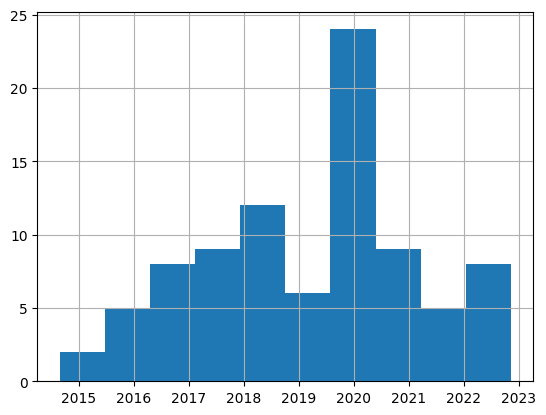

In [198]:
data_terminated[data_terminated["EmploymentStatus"] == "Voluntarily Terminated"]["DateofTermination"].hist()